In [59]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

import numpy.random as rnd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.base import clone

from sklearn import datasets

from sklearn.linear_model import LogisticRegression

# Linear Regression

## The Normal Equation

Let's generate some linear-looking data to test the Normal Equation (theta = inv(X' * X) * X' * y)

In [2]:
X = 2 * np.random.rand(100, 1) # X == 100 x 1
y = 4 + 3 * X + np.random.randn(100, 1) # y = 100 x 1

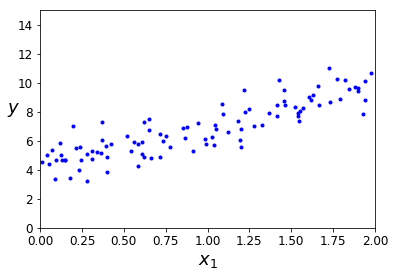

In [3]:
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Let's compute theta using the Normal Equation:

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The actual function we used to generate the data is y = 4 + 3x0 + Gassian noise. Let's see what the equation found:

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for theta0 = 4 and theta1 = 3. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using theta_best (theta hat):

In [6]:
X_new = np.array([[0], [2]]) # 2 x 1
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance == 2 x 2
y_predict = X_new_b.dot(theta_best) # 2 x 1
y_predict

array([[4.21509616],
       [9.75532293]])

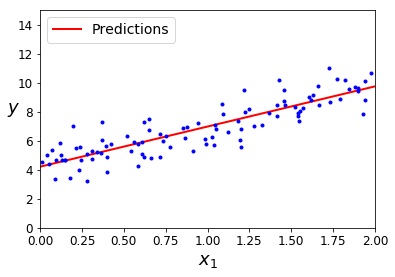

In [7]:
plt.plot(X_new, y_predict, 'r-', linewidth=2, label='Predictions')
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

Hence, at x1=0, we can see y=3.94, and at x1=2, y=9.92

The equivalent code using sklearn's LinearRegression looks like this:

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[4.21509616] [[2.77011339]]


array([[4.21509616],
       [9.75532293]])

We get the same results.

The sklearn LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for "least squares"), which we could call directly:

In [9]:
theta_best_svd, residuals, rand, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes X+ * y where X+ is the *pseudoinverse* of X using np.linalg.pinv() to compute the pseudoinverse directly:

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

### Computational Complexity

The Normal Equation gets very slow when the number of features grows large due to computational complexity. Yet, it handles them efficiently. And once we've trained our Linear Regression model (using Normal Equation or any other algorithm), predictions are very fast. Computational complexity is linear: making predictions on twice as many instances/features will just take roughly twice as long.

## Gradient Descent

You start by filling theta with random values (*random initialization*), and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (eg the MSE) until the algorithm converges to a minimum.

An important parameter is the size of the steps, determined by the *learning rate* hyperparameter. If too small, it'll have to go through too many iterations to converge. If too large, it might jump across the valley and end up on the other side, possibly even higher up than we were before, diverging.

And not all cost functions are convex bowls. Might be holes, ridges, etc. making convergence to the minimum very difficult.

Fortunately, the MSE cost function for Linear Regression is a *convex function* so local minima are not an issue. So gradient descent is guaranteed to converge at a global minimum.

But make sure to do feature scaling (ie StandardScaler) or else it will take much longer to converge.

### Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regards to each model parameter thetaj (*partial derivative*).

d/dthetaj MSE(theta) = (2/m) * sum(theta' * x(i) - y(i)) * x(i)j

= (2/m) * X' * (X * theta - y)

It's called *batch* gradient descent because it uses the whole batch of training data at every step. The result is terribly slow on very large training sets. However, it scales well with large number of features compared to using the Normal Equation.

Now that we have the gradient vector, which points upward, subtract VMSE(theta) (VMSE = vector MSE) from theta. This is where the learning rate comes into play: multiply the radient vector by alpha to determine the size of the downhill step.

In [11]:
alpha = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - alpha * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

In [13]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

That's exactly what LinearRegression found. Gradient Descent worked perfectly.

To find a good learning rate, you can use grid search. However, you may want to limit the number of iterations so that grid search can eliminate models that take too long to converge.

How do we set number of iterations? If it's too low, we'll still be far away from the optimal solution when the algorithm stops; if too high, we'll waste time while the model parameters don't change anymore.

A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny--when its norm becomes smaller than a tiny number called epsilon (called the *tolerance*) because at this point GD has (almost) reached the minimum.

#### Convergence Rate

When the cost function is convex and slope doesn't change abruptly (MSE cost function), Batch Gradient Descent with a fixed learning rate has a *convergence rate* of O(1 / iterations). Aka if we divide the tolerance (epsilon) by 10 (to have a more precise solution), then the algorithm will have to run about 10 times more iterations.

In [14]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

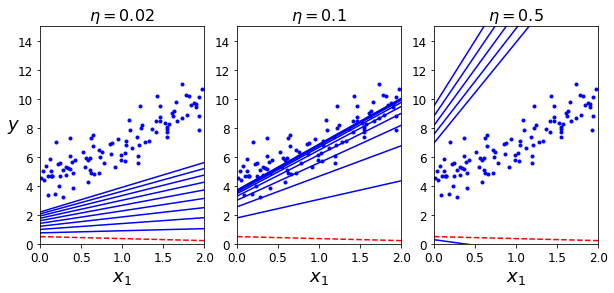

In [15]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

## Stochastic Gradient Descent

Because Batch GD uses the whole training set to compute the gradients at every step, it's very slow when the training set is large.

Conversely, *Stochastic Gradient Descent* just picks a random instance in the training set at every step and computes the gradients based on that single instance. This makes it much faster, and more scalable.

However, due to its stochastic (ie random) nature, it's much less regular than Batch GD: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. But it will never fully settle down, so the final parameter values are good, but not optimal.

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so Stochastic GD has a better chance of finding the global minimum than Batch GD. So randomness is good to escape from local optima, but bad because algorithm never settles at the minimum.

A solution to this is to gradually reduce the learning rate. The steps start out large to escape local minima, then get smaller and smaller, allowing it to settle at the global minimum. It's called *simulated annealing*.

The function that determines the learning rate at each iteration is called the *learning schedule*. If it's reduced too quickly, we may get stuck in a local minimum, or frozen halfway down. If it's reduced too slowly, we may jump around the minimum for a long time and end up with a suboptimal solution if we halt training too early.

This code implements Stochastic GD using a simple learning schedule:

In [16]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

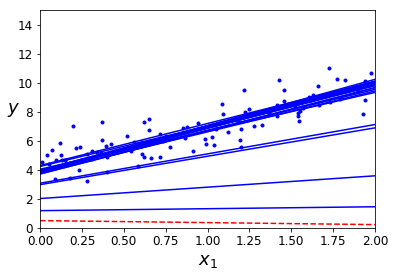

In [17]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
plt.show()                                           # not shown

This figure shows the first 10 steps of training (notice how irregular the steps are)

We iterate by rounds of *m* iterations; each round is called an *epoch*. Batch GD iterated 1000 times through the whole training set; this code goes through the training set only 50 times and reaches a fairly good solution:

In [18]:
theta

array([[4.21076011],
       [2.74856079]])

Since instances are picked randomly, some instances may be picked several times per epoch while others may not be picked at all. If you want to be sure that the algorithm goes throughe very instance at each apoch, another approach is to shuffle the training set, then go through it instance by instance, then shuffle it again, and so on. However, this generally converges more slowly.

Sklearn has the SGDRegressor class, which defaults to optimizing the squared error cost function. The following code runs 50 epochs, starting with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one), and it does not use any regularization (penalty=None):

In [19]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None,
                      eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

Once again, we find a solution very close to the one returned by the Normal Equation:

In [20]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.16782089]), array([2.72603052]))

## Mini-batch Gradient Descent

At each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of MBGD over SGD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

It's less erratic than SGD, especially with fairly large mb's. So it'll get closer to minimum, but may be harder to escape local minima.

In [21]:
theta_path_mgd = [] # to track the path of theta for graphing purposes

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1) # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [22]:
theta

array([[4.25214635],
       [2.7896408 ]])

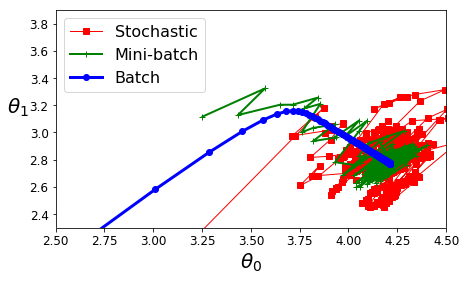

In [23]:
# graph of gradient descent paths
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

# Polynomial Regression

We can use a linear model to fit nonlinear data by adding powers of each feature as new features, then training a linear model on this extended set of features.

Here's an example. First we'll generate some nonlinear data, based on a simple *quadratic equation* (plus some noise).

In [24]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

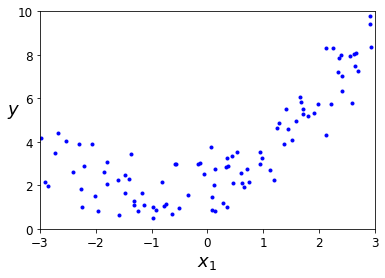

In [25]:
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [26]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.38942838])

In [27]:
X_poly[0]

array([2.38942838, 5.709368  ])

X_poly now contains the features of X *plus* the square of this feature as a new column. Now we can fit a LinearRegression model to this extended training data:

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

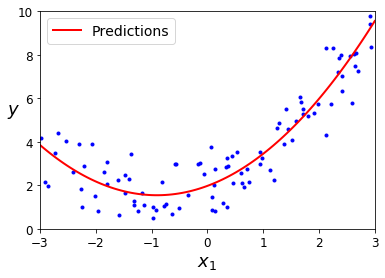

In [29]:
# plot the quadratic regression
X_new = np.linspace(-3, 3, 100).reshape(100,1) # new X to graph x-axis from -3 to 3
X_new_poly = poly_features.transform(X_new) # create poly_features to make quadratic
y_new = lin_reg.predict(X_new_poly) # predict on new x w/ poly
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-', linewidth=2, label='Predictions')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.axis([-3,3,0,10])
plt.show()

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (something a plain Linear Regression model can't do). PolynomialFeatures also adds all combinations of features up to the given degree. ie ab, a^2b, ab^2.

PolynomialFeatures transforms an array containing n features into an array containing (n+d)! / (d!n!).

This can cause an explosion very quickly when starting with a high level of features.

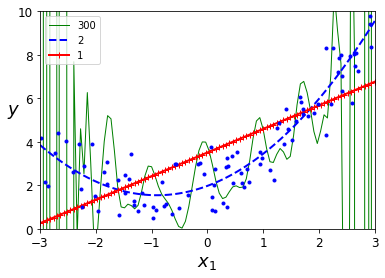

In [30]:
# For visualization

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

# Learning Curves

Another way to estimate a model's over/underfitting, other than cross-validation, is to look at the *learning curves*. These are plots of the model's performance on the training set and the validation set as a function of the training set size.

To generate the plots, simply train the model several times on different sized subsets of the training set. The following code defines a function that plots the learning curves of a model given some training data:

In [31]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      y,
                                                      test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Look at the learning curves of the plain Linear Regression model (a straight line):

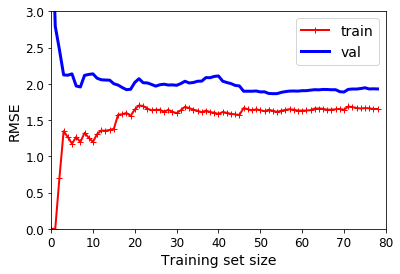

In [32]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

The **training set** curve begins at 0 for the first couple examples because it can fit those perfectly (since it was trained on those y-values). But as new instances are added, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it's not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn't make the average error much better or worse.

The **validation set** curve begins at very high errors because it is trained on very few training instances. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. But once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.

These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high.

If a model is underfitting the training data, adding more training examples will not help. We need to use a more complex model or come up with better features.

Now let's look at the learning curves of a 10th-degree polynomial model on the same data:

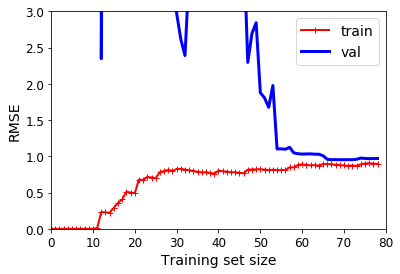

In [33]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

These learning curves look a bit like the previous ones, but there's 2 important differences:

-  The error on the training set is much lower than with the Linear Regression model.


-  There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation set, which is the hallmark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

#### The Bias/Variance Tradeoff

An important theoretical result of statistics and Machine Learning is the fact that a model's generalization error can be expressed as the sum of three very different errors:

*Bias*
-  This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic (high bias). A high-bias model is most likely to underfit the training data.

*Variance*
-  This part is due to the model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

*Irreducible Error*
-  This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (ie fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model's complexity (higher degree polynomial) will typically increase its variance and reduce its bias. Conversely, reducing a model's complexity (lower-degree polynomial) increases its bias and reduces its variance. This is why it's called a tradeoff.

# Regularized Linear Models

A typical way to reduce overfitting is to regularize the model: the fewer degrees of freedom it has, the harder to overfit. Ie a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. Three ways of doing this are Ridge Regression, Lasso Regression, and Elastic Net, which implement three different ways to constrain the weights.

### Ridge Regression

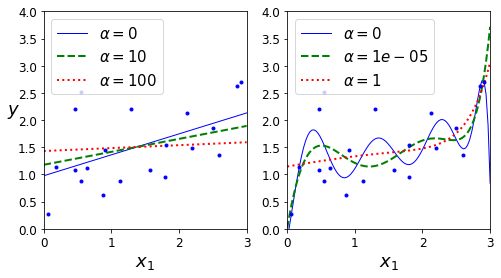

In [34]:
# Code for the figures below for illustrative purposes
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

*Ridge Regression* is a regularized version of Linear Regression: a *regularization term* equal to ( alpha * sum(thetai^2) ) is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

Note that the regularization term should only be added to the cost function during training. Once the model is trained, we want to evaluate the model's performance using the unregularized performance measure.

It's quite common for the cost function used during training to be different from the performance measure used for testing. Reasons for this could be regularization, or that a good training cost function should have optimization-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective. A good example of this is a classifier trained using a cost function such as the log loss, but evaluated using precision/recall.

The hyperparameter alpha controls how much you want to regularize the model. If alpha=0 then Ridge Regression is just Linear Regression. If alpha is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean.

Ridge Regression cost function:

J(theta) = MSE(theta) + alpha * (1/2) * sum(thetai^2)

Note the bias term theta0 isn't regularized (sum starts at i=1, not 0). If we define w as the vector of feature weights (theta1 to thetan), then the regularization term is simply equal to 1/2(||w||2)^2, where || . ||2 represents the l2 norm of the weight vector (||w|| means the floor of w).

For *Gradient Descent*, just add (alpha * w) to the MSE gradient vector.

-  (2/m) * X' * (X * theta - y) + alpha * w

Note: it is important to scale the data (ie StandardScaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models.

We can perform Ridge Regression either by computing a closed-form equation or by performing Gradient Descent. The pros and cons are the same.

For *closed-form equation*:

-  theta = (X' * X + alpha * A)^(-1) * X' * y

Where A is the nxn *identity matrix* except with a 0 in the top-left cell, corresponding to the bias term).

Here's how to perform Ridge Regression with sklearn using a closed-form solution using a matrix factorization technique by Andre-Louis Cholesky):

In [35]:
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

And using Stochastic Gradient Descent:

In [36]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, 
                       penalty='l2', 
                       random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.49905184])

The penalty hypermarameter sets the type of regularization term to use. Specifying 'l2' indicates that you want SGD to add a regularization term to the cost function equal to half the square of the l2 norm of the weight vector: this is simply Ridge Regression.

### Lasso Regression

*Least Absolute Shrinkage and Selection Operator Regression* (simply called *Lasso Regression*) is another regularized version of the Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the l1 norm of the weight bector instead of half the square of the l2 norm:

j(theta) = MSE(theta) + alpha * sum( |thetai| )

The figure below is the same as the previous Ridge models but now they're Lasso models and use smaller alpha values.

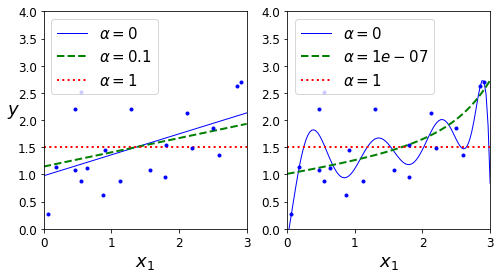

In [37]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (ie set them to zero). For example, the dashed line in the right plot (with alpha=10^-7) looks quadratic, almost linear: all the weights for the high-degree polynomial features are equal to zero. In other words, Lasso Regression automatically performs feature selection and outputs a *sparse model* (ie with few nonzero feature weights).

You can get a sense of why this is the case by looking at Figure 4-19: on the top-left
plot, the background contours (ellipses) represent an unregularized MSE cost func‐
tion (α = 0), and the white circles show the Batch Gradient Descent path with that
cost function. The foreground contours (diamonds) represent the ℓ1 penalty, and the
triangles show the BGD path for this penalty only (α → ∞). Notice how the path first reaches θ1
 = 0, then rolls down a gutter until it reaches θ2
 = 0. On the top-right plot,
the contours represent the same cost function plus an ℓ1
 penalty with α = 0.5. The
global minimum is on the θ2
 = 0 axis. BGD first reaches θ2 = 0, then rolls down the
gutter until it reaches the global minimum. The two bottom plots show the same
thing but uses an ℓ2 penalty instead. The regularized minimum is closer to θ = 0 than
the unregularized minimum, but the weights do not get fully eliminated.

In [50]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

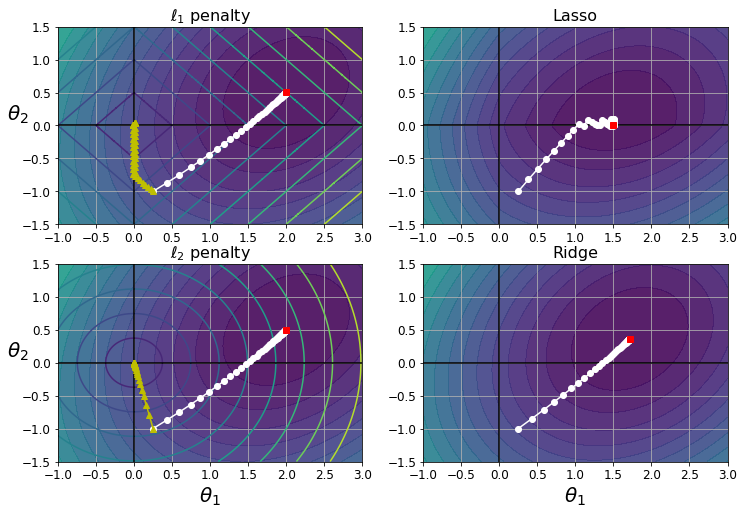

In [51]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

plt.show()

**Note**: On the Lasso cost function, the BGD path tends to bounce across
the gutter toward the end. This is because the slope changes
abruptly at θ2 = 0. You need to gradually reduce the learning rate in
order to actually converge to the global minimum.

The Lasso cost function is not differentiable at thetai=0 (for i=1,2,...,n), but Gradient Descent still works fine if you use a *subgradient vector* g^15 instead when any thetai=0. Here's the Lasso Regression subgradient vector equation to use for Gradient Descent:

-  g(theta, J) = VectorthetaMSE(theta) + alpha * sign(thetai)

where sign(thetai) is a vector =

-  -1 if thetai < 0
-  0 if thetai = 0
-  +1 if thetai > 0

In [42]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])
# we could also use SGDRegressor(penalty='l1')

array([1.53788174])

### Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso's regularization terms, and you can control the mix ratio *r*. When *r*=0, Elasti Net is equivalent to Ridge Regression, and when r=1, it is equivalent to Lasso Regression.

Elastic Net cost function:

J(theta) = MSE(theta) + r * alpha * sum( |thetai| + (1-r)/2 * alpha * sum(thetai^2)

When do we use Linear, Ridge, Lasso, or Elastic Net Regression?

It's almost always preferable to have at least a little bit of regularization, so generally we should avoid plain Linear Regression.

Ridge is a good default.

If we suspect that only a few features are actually useful, prefer Lasso or Elastic Net since they tend to reduce the useless features' weights down to zero.

In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

Here's a short example using ElasticNet (l1_ratio corresponds to the mix ratio *r*):

In [43]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

Another way to regularize iterative learning algorithms like Gradient Descent is to stsop training as soon as the validation error reaches a minimum. This is called *early stopping*. Below is a complex model (high-degree polynomial regression model) being trained using BGD. As the epochs go by, the algorithm learns and its prediction error (RMSE) on the training set naturally goes down, and so does its prediction error on the validation set. However, after a while the validation error stops decreasing and actually starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a "beautiful free lunch."

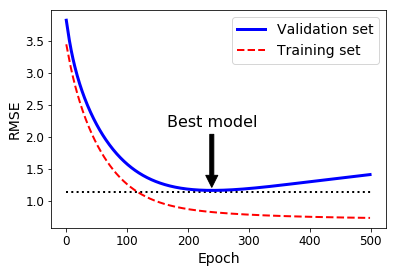

In [44]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

**Note:** With Stochastic and Mini-batch Gradient Descent, the curves are
not so smooth, and it may be hard to know whether you have
reached the minimum or not. One solution is to stop only after the
validation error has been above the minimum for some time (when
you are confident that the model will not do any better), then roll
back the model parameters to the point where the validation error
was at a minimum.

Here's a basic implementation of early stopping:

In [48]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty,
                       warm_start=True,
                       penalty=None,
                       learning_rate='constant',
                       eta0=0.0005, random_state=42)

minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [49]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
        verbose=0, warm_start=True))

**Note**: with warm_start=True, when the fit() method is called, it just continues training where it left off instead of restarting from scratch.

# Logistic Regression

Some regression algorithms can be used for classification as well (and vice versa). *Logistic Regression* is commonly used to estimate the probability that an instance belongs to a particular class (ie what is the probability that this email is spam?). If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled "1"), or else it predicts that it does not (ie it belongs to the negative class, labeled "0"). This makes it a binary classifier.

### Estimating Probabilities

A Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model, it outputs the *logistic* of this result.

Vectorized Logistic Regression model estimated probability:

-  p = htheta(x) = sigma(theta' * x)

The *logistic* (also called the *logit*) noted sigma is a *sigmoid function* (ie *S*-shaped) that outputs a number between 0 and 1.

Sigmoid function:

-  Sigma(t) = 1 / (1 + exp(-t))

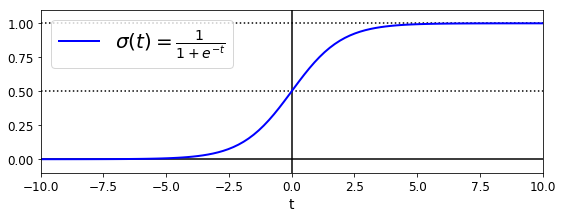

In [52]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

Once the Logistic Regression model has estimated the probability p = htheta(x) that an instance x belongs to the positive class, it can make its prediction y easily:

y = 
-  0 if p < 0.5
-  1 if p >= 0.5

Notice that sigma(t) < 0.5 when t < 0, and sigma(t) >= 0.5 when t >= 0. So a Logistic Regression model predicts 1 if theta' * x is positive, and 0 if it is negative.

### Training and Cost Function

The objective of training is to set the parameter vector theta so that the model estimates high probabilities for positive instnaces (y=1) and low probabilities for negative instances (y=0). This idea is captured by the cost function for a single training instnce x:

c(theta) = 

-  -log(p) if y=1
-  -log(1-p) if y=0

This function makes sense because -log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for negative instances. On the other hand, -log(t) is close to 0 when t is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for negative instance or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is simply the average cost over all training instances. It can be written in a single expression called the *log loss*:

-  j(theta) = -1/m * sum( yi * log(pi) + (1-yi) * log(1-pi) )

The bad news is that there is no known closed-form equation to compute the value of theta that minimizes this cost function (there is no equivalent of the Normal Equation). But the good news is that this cost function is convex, so Gradient Descent (or any other optimization algorithm) is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough). The partial derivatives of the cost function with regards to the jth model paramether thetaj is:

-  d/dthetaj J(theta) = 1/m * sum( (sigma(theta' * xi) - yi) * xij)

This equation looks very much like the BGD derivative equation. For each instance it computes the prediction error and multiplies it by the jth feature value, and then it computes the average over all training instances. Once we have the gradient vector containing all the partial derivatives we can use it in the BGD algorithm. For SGD, we would just take one instance at a time, and for MBGD we would use a mini-batch at a time.

## Decision Boundaries

We'll use the iris dataset to illustrate Logistic Regression. It contains the sepal nd petal length and width of 150 iris flows of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica.

Let's build a classifier to detect the Iris-Virginica type based only on the petal width feature.

In [54]:
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [55]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [58]:
# load the dataset
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int) # 1 if Iris-Virginica, else 0

In [60]:
# train Logistic Regression model
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Let's look at the model's estimated probabilities for flowers with petal widths varying from 0 to 3 cm:

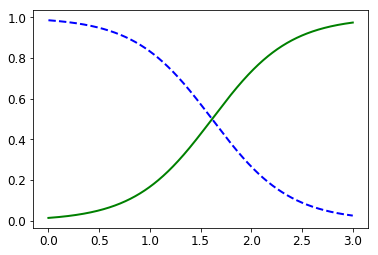

In [61]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], 'g-', linewidth=2,
         label='iris-Virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', linewidth=2,
         label='Not Iris-Virginica')

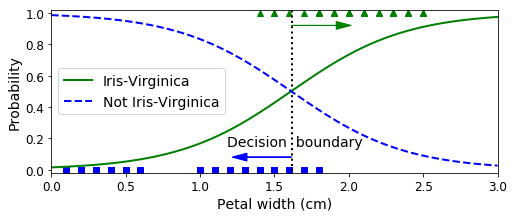

In [62]:
# Here's a fancier way of plotting this figure
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

The petal width of Iris-Virginica flowers (represented by triangles) ranges from 1.4
cm to 2.5 cm, while the other iris flowers (represented by squares) generally have a
smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice that there is a bit of over‐
lap. Above about 2 cm the classifier is highly confident that the flower is an IrisVirginica (it outputs a high probability to that class), while below 1 cm it is highly
confident that it is not an Iris-Virginica (high probability for the “Not Iris-Virginica”
class). In between these extremes, the classifier is unsure. However, if you ask it to
predict the class (using the predict() method rather than the predict_proba()
method), it will return whichever class is the most likely. Therefore, there is a decision
boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal
width is higher than 1.6 cm, the classifier will predict that the flower is an IrisVirginica, or else it will predict that it is not (even if it is not very confident):

In [63]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

The figure below shows the same dataset but this time displaying two features: petal width
and length. Once trained, the Logistic Regression classifier can estimate the probabil‐
ity that a new flower is an Iris-Virginica based on these two features. The dashed line
represents the points where the model estimates a 50% probability: this is the model’s
decision boundary. Note that it is a linear boundary.17 Each parallel line represents the
points where the model outputs a specific probability, from 15% (bottom left) to 90%
(top right). All the flowers beyond the top-right line have an over 90% chance of
being Iris-Virginica according to the model.

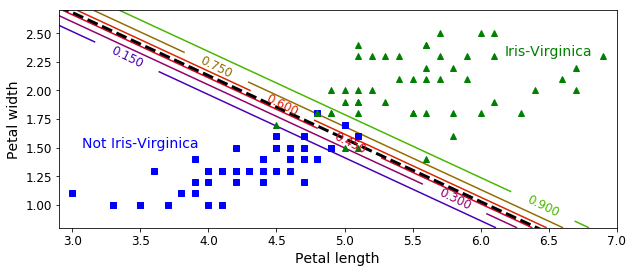

In [64]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

Just like the other linear models, Logistic Regression models can be regularized using l1 or l2 penalties. Scikit-Learn actually adds an l2 penalty by default.

The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not alpha (as in other linear models), but its inverse: C. The higher the value of C, the *less* the model is regularized.

# Softmax Regression

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called *Softmax Regression*, or *Multinomial Logistic Regression*.

The idea is quite simple: when given an instance **x**, the Softmax Regression model first computes a score sk(x) for each class k, then estimates the probability of each class by applying the *softmax function* (also called the *normalized exponential*) to the scores. The equation to compute sk(**x**) should look familiar, as it is just like the equation for Linear Regression prediction.

Softmax score for class k:

-  sk(x) = thetak' * x

Note that each class has its own dedicated parameter vector thetak. All these vectors are typically stored as rows in a *parameter matrix*.

Once you have computed the score of every class for the instance **x**, you can estimate the probability pk that the instance belongs to class k by running the scores through the softmax function: it computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials).

Softmax function:

-  pk = sigma(s(x))k = exp(sk(x)) / sumj-->K( exp(sj(x) )

    -  *K* is the number of classes
    -  **s(x)** is a vector containing the scores of each class for the instance **x**.
    -  sigma(**s(x)**)k is the estimated probability that the instance **x** belongs to the class *k* given the scores of each class for that instance.
    
Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score).

Softmax Regression classifier prediction:

-  y = argmaxk sigma(s(**x**))k = argmaxk sk(x) = argmaxk (thetak' * x)

    -  The *argmax* operator returns the value of a variable that maximizes a function. In this equation, it returns the value of *k* that maximizes the estimated probability of sigma(**s(x)**)k.
    
The Softmax Regression classifier predicts only one class at a time (ie it is multiclass, not multioutput) so it should be used only with mutually exclusive classes such as different types of plants. You cannot use it to recognize multiple people in one picture.

Now that you know how the model estimates probabilities and makes predictions,
let’s take a look at training. The objective is to have a model that estimates a high
probability for the target class (and consequently a low probability for the other
classes). Minimizing the cost function below, called the *cross entropy*, should lead to this objective because it penalizes the model when it estimates
a low probability for a target class. Cross entropy is frequently used to measure how
well a set of estimated class probabilities match the target classes.

Cross entropy cost function:

-  j(theta) = -1/m * sum 1-->m(sum 1-->K( yik * log(pik) )

    - yik is equal to 1 if the target class for the ith instance is *k*; otherwise, it is equal to 0.
    
Notice that when there are just two classes (*K*=2), this cost function is equivalent to Logistic Regression's cost function (log loss).

Cross entropy gradient vector for class k:

-  vector thetak J(theta) = 1/m * sum1-->m( (pik - yik) * xi )

Now we can compute the gradient vector for every class, then use Gradient Descent (or any other optimization algorithm) to find the parameter martix theta that minimizes the cost function.

Let's use Softmax Regression to classify the iris flowers into all three classes. Scikit-Learn's LogisticRegression uses one-versus-all by default when you train it on more than two classes, but you can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression instead. You must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver. It also applies l2 regularization by default, which you can control using the hyperparameter C.

In [65]:
X = iris['data'][:, (2, 3)] # petal length, petal width
y = iris['target']

softmax_reg = LogisticRegression(multi_class='multinomial',
                                solver='lbfgs',
                                C=10,
                                random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

So the next time we find an iris with 5cm long and 2cm wide petals, we can ask our model to tell us what type of iris it is, and it will answer Iris-Virginica (class 2) with 94.2% probability (or Iris-Versicolor with 5.8% probability):

In [66]:
softmax_reg.predict([[5, 2]])

array([2])

In [67]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

The figure below shows the resulting decision boundaries, represented by the background colors. Notice that the decision boundaries between any two classes are linear. The figure also shows the probabilities for the Iris-Versicolor class, represented by the curved lines (ie the line labeled with 0.450 represents the 45% probability boundary). Notice that the model can predict a class that has an estimated probability below 50%. For example, at the point where all decision boundaries meet, all classes have an equal estimated probability of 33%.

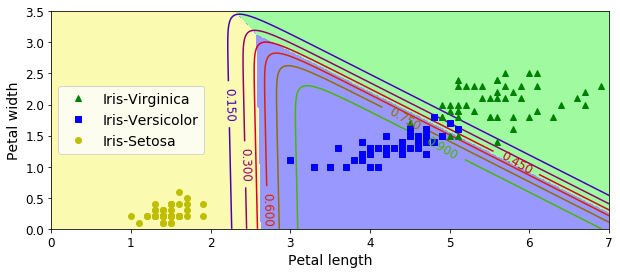

In [68]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()